## Problem Statement

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

## Import Packages

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.stem.porter import *
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
import lightgbm as lgb
import optuna

## Set file paths for train and predict datasets

In [2]:
train_dataset = "Dataset/train.csv"
predict_dataset = "Dataset/test.csv"

## Helper functions for data preprocessing

In [3]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    
    return input_txt

In [4]:
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

## Data Preprocessing

#### Read train and predict data

In [5]:
train_df  = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)
print(train_df.head())
print("\nTrain Data: {}".format(train_df.shape))
print("Predict Data: {}".format(predict_df.shape))

   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

Train Data: (31962, 3)
Predict Data: (17197, 2)


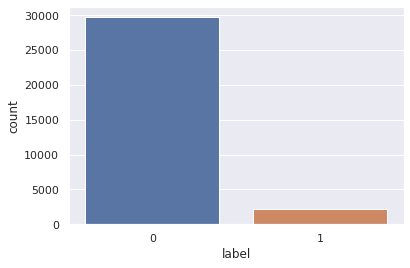

In [6]:
# Display countplot for different classes in training data
sns.set(style="darkgrid")
ax = sns.countplot(x="label", data=train_df)

#### Extract "label" field from train_df into NumPy array

In [7]:
train_y = np.array([train_df['label'].values]).T
print("train_y: {}".format(train_y.shape))

train_y: (31962, 1)


In [8]:
# Combine train and predict data
combined_df = train_df.append(predict_df, ignore_index=True)
print(combined_df.shape)

(49159, 3)


#### Removing Twitter Handles (@user)

In [9]:
combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['tweet'], "@[\w]*")
print(combined_df.head())

   id  label                                              tweet  \
0   1    0.0   @user when a father is dysfunctional and is s...   
1   2    0.0  @user @user thanks for #lyft credit i can't us...   
2   3    0.0                                bihday your majesty   
3   4    0.0  #model   i love u take with u all the time in ...   
4   5    0.0             factsguide: society now    #motivation   

                                          tidy_tweet  
0    when a father is dysfunctional and is so sel...  
1    thanks for #lyft credit i can't use cause th...  
2                                bihday your majesty  
3  #model   i love u take with u all the time in ...  
4             factsguide: society now    #motivation  


#### Removing Punctuations, Numbers, and Special Characters

In [10]:
combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
print(combined_df.head())

   id  label                                              tweet  \
0   1    0.0   @user when a father is dysfunctional and is s...   
1   2    0.0  @user @user thanks for #lyft credit i can't us...   
2   3    0.0                                bihday your majesty   
3   4    0.0  #model   i love u take with u all the time in ...   
4   5    0.0             factsguide: society now    #motivation   

                                          tidy_tweet  
0    when a father is dysfunctional and is so sel...  
1    thanks for #lyft credit i can t use cause th...  
2                                bihday your majesty  
3  #model   i love u take with u all the time in ...  
4             factsguide  society now    #motivation  


#### Removing Short Words

In [11]:
combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
print(combined_df.head())

   id  label                                              tweet  \
0   1    0.0   @user when a father is dysfunctional and is s...   
1   2    0.0  @user @user thanks for #lyft credit i can't us...   
2   3    0.0                                bihday your majesty   
3   4    0.0  #model   i love u take with u all the time in ...   
4   5    0.0             factsguide: society now    #motivation   

                                          tidy_tweet  
0  when father dysfunctional selfish drags kids i...  
1  thanks #lyft credit cause they offer wheelchai...  
2                                bihday your majesty  
3                         #model love take with time  
4                     factsguide society #motivation  


#### Tokenization

In [12]:
tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x: x.split())
print(tokenized_tweet.head())

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object


#### Stemming

In [13]:
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
print(tokenized_tweet.head())

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object


#### Join tokens to create the sentences

In [14]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combined_df['tidy_tweet'] = tokenized_tweet

## Exploratory Data Analysis

#### Understanding the common words used in the tweets: WordCloud

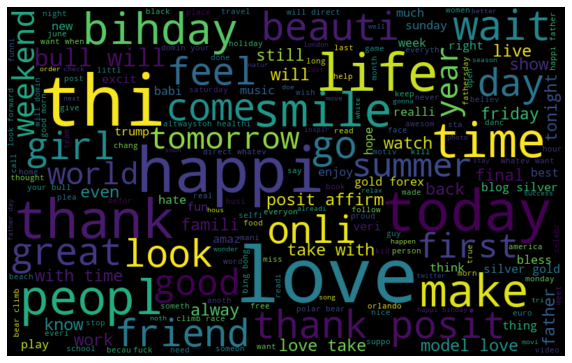

In [15]:
all_words = ' '.join([text for text in combined_df['tidy_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Words in non racist/sexist tweets

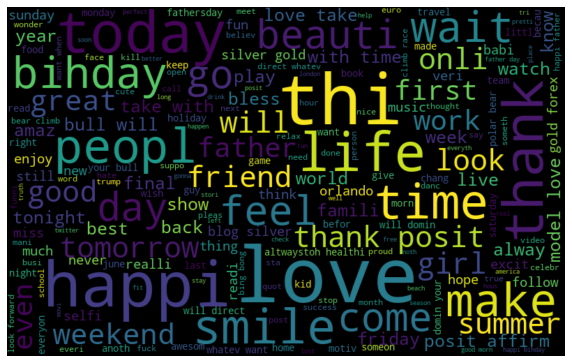

In [16]:
normal_words =' '.join([text for text in combined_df['tidy_tweet'][combined_df['label'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Racist/Sexist Tweets

In [ ]:
negative_words = ' '.join([text for text in combined_df['tidy_tweet'][combined_df['label'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Understanding the impact of Hashtags on tweets sentiment

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.

We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets.

In [18]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(combined_df['tidy_tweet'][combined_df['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combined_df['tidy_tweet'][combined_df['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

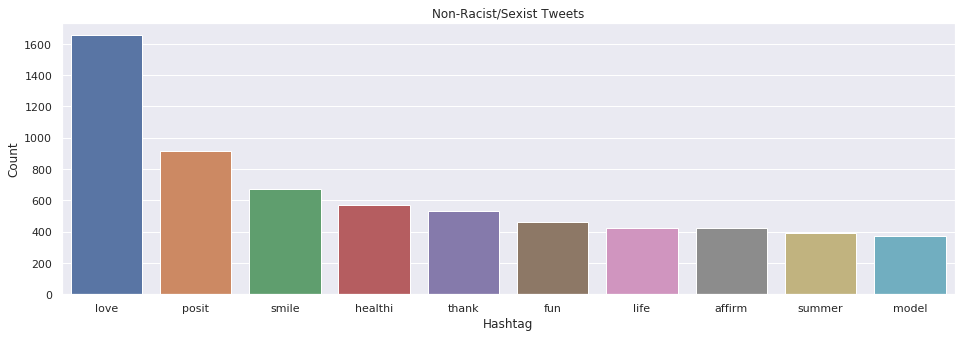

In [19]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})
d = d.nlargest(columns="Count", n = 10)         # selecting top 10 most frequent hashtags

plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title("Non-Racist/Sexist Tweets")
plt.show()

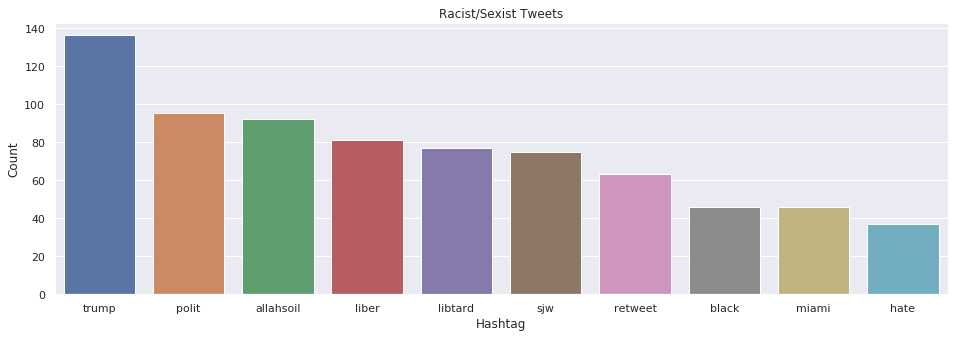

In [20]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
e = e.nlargest(columns="Count", n = 10)         # selecting top 10 most frequent hashtags

plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title("Racist/Sexist Tweets")
plt.show()

## Feature Engineering

#### Bag-of-Words Features

In [21]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combined_df['tidy_tweet'])      # bag-of-words feature matrix
bow_df = pd.DataFrame(bow.toarray(), columns=bow_vectorizer.get_feature_names())
combined_df = pd.concat([combined_df, bow_df], axis=1)

#### TF-IDF Features

In [22]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combined_df['tidy_tweet'])  # TF-IDF feature matrix
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
combined_df = pd.concat([combined_df, tfidf_df], axis=1)

## Final dataset preparation

#### Create train and predict Numpy arrays and scale them

In [23]:
## Drop redundant columns from the dataframe
combined_df.drop(['label', 'id', 'tweet', 'tidy_tweet'], inplace=True, axis=1)

In [24]:
# Segregate combined_df into train/predict datasets
train_x = combined_df[:31962]
predict_x = combined_df[31962:]

print("train_x: {}".format(train_x.shape))
print("predict_x: {}".format(predict_x.shape))

train_x: (32165, 1998)
predict_x: (16994, 1998)


In [25]:
# Scale the train_x/predict_x arrays
scaler_x = StandardScaler().fit(train_x)
train_x = scaler_x.transform(train_x)
predict_x = scaler_x.transform(predict_x)
train_x_full = np.copy(train_x)
train_y_full = np.copy(train_y)

#### Split training data into train/test datasets

In [26]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.075, random_state=1)
for train_index, test_index in sss.split(train_x, train_y):
    train_x, test_x = train_x[train_index], train_x[test_index]
    train_y, test_y = train_y[train_index], train_y[test_index]

print("------------------------- Training Dataset -------------------------")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

print("\n------------------------- Test Dataset -------------------------")
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

ValueError: Found input variables with inconsistent numbers of samples: [32165, 31962]

## Save the datasets in NPZ file (for reusability)

In [ ]:
np.savez_compressed('Dataset/Twitter_Sentiment_Analysis_dataset.npz',
                    Xtrain_full=train_x_full, Ytrain_full=train_y_full,
                    Xtrain=train_x, Ytrain=train_y,
                    Xtest=test_x, Ytest=test_y,
                    Xpredict=predict_x)

## Load datasets from the NPZ file

In [ ]:
processed_dataset = np.load('Dataset/Twitter_Sentiment_Analysis_dataset.npz', allow_pickle=True)

Xtrain_full, Ytrain_full = processed_dataset['Xtrain_full'], processed_dataset['Ytrain_full']
Xtrain, Ytrain = processed_dataset['Xtrain'], processed_dataset['Ytrain']
Xtest, Ytest = processed_dataset['Xtest'], processed_dataset['Ytest']
Xpredict = processed_dataset['Xpredict']

print("------------------------- Training Dataset -------------------------")
print("Xtrain_full shape: {}".format(Xtrain_full.shape))
print("Ytrain_full shape: {}".format(Ytrain_full.shape))
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

## Hyperparameter search using Optuna

In [ ]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

In [ ]:
def objective(trial):
    
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 1e-1),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-4, 1.0),
        "num_leaves": trial.suggest_int("num_leaves", 31, 150),
        "max_depth": trial.suggest_int("max_depth", 7, 20),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 20),
    }
    
    y_pred = 0
    counter = 0
    
    for train, val in kfold.split(Xtrain, Ytrain):
        counter += 1

        train_x, train_y = Xtrain[train], Ytrain[train]
        val_x, val_y = Xtrain[val], Ytrain[val]

        lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
        lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

        model = lgb.train(params, lgtrain, num_boost_round=5000, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=False)
        pred = model.predict(Xtest, num_iteration=model.best_iteration)

        y_pred += pred

    y_pred /= float(counter)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    score = accuracy_score(Ytest, y_pred_binary)

    return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

## Model Building: Sentiment Analysis

In [ ]:
# Define model hyperparameters
params = {}
params["objective"] = 'binary'
params['metric'] = 'binary_logloss'
params['boosting'] = 'gbdt'
params["max_depth"] = 12
params["num_leaves"] = 39
params["learning_rate"] = 0.017
params["bagging_fraction"] = 0.75
params["feature_fraction"] = 0.56
params["bagging_freq"] = 15
params["bagging_seed"] = 10
params["lambda_l2"] = 0.12
params["min_data_in_leaf"] = 6
params["verbosity"] = -1
num_rounds = 5000

In [ ]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
y_pred = 0

In [ ]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1

    train_x, train_y = Xtrain[train], Ytrain[train]
    val_x, val_y = Xtrain[val], Ytrain[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred = model.predict(Xtest, num_iteration=model.best_iteration)

    y_pred += pred

y_pred /= float(counter)

## Validate the model

In [ ]:
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

In [ ]:
#Print accuracy
acc_score = accuracy_score(Ytest, y_pred_binary)
print('Overall accuracy of ANN model:', acc_score)

In [ ]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(Ytest, y_pred_binary)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

In [ ]:
#Print Confusion Matrix
cm = confusion_matrix(Ytest, y_pred_binary)
labels = ['Female', 'Male']
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.5);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## Train the model on entire training data

In [ ]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

In [ ]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain_full, Ytrain_full):
    counter += 1

    train_x, train_y = Xtrain_full[train], Ytrain_full[train]
    val_x, val_y = Xtrain_full[val], Ytrain_full[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred1 = model.predict(Xpredict, num_iteration=model.best_iteration)

    y_pred += pred1

y_pred /= float(counter)

In [ ]:
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

## Create submission file

In [ ]:
temp_df = pd.DataFrame(y_pred_binary, columns=['prediction'])
submit_df = pd.read_csv("Dataset/sample_submission.csv")
submit_df['label'] = temp_df['prediction']
submit_df.head()

In [ ]:
submit_df.to_csv("predictions.csv", index=False)